<a href="https://colab.research.google.com/github/thinhphan97/mini_project/blob/main/Chest_X_ray_Abnormalities_Detetion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [24]:
import numpy as np
import pandas as pd
import cv2
from ast import literal_eval
import cv2
import matplotlib.pyplot as plt

import glob

train_df = pd.read_csv("/gdrive/MyDrive/VinBigData Chest X-ray Abnormalities Detetion/train.csv")
train_df.columns =['image_id','x_min', 'y_min',	'x_max', 'y_max','class_id']

train_df.head()

,image_id,x_min,y_min,x_max,y_max,class_id
0,train512/051132a778e61a86eb147c7c6f564dfe.png,290,130,359,190,Aortic enlargement
1,train512/051132a778e61a86eb147c7c6f564dfe.png,211,226,459,298,Cardiomegaly
2,train512/051132a778e61a86eb147c7c6f564dfe.png,214,237,453,289,Cardiomegaly
3,train512/051132a778e61a86eb147c7c6f564dfe.png,354,81,401,108,Pleural thickening
4,train512/051132a778e61a86eb147c7c6f564dfe.png,284,130,359,190,Aortic enlargement


In [25]:
train_df['x_mid'] = train_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

train_df['w'] = train_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
train_df['h'] = train_df.apply(lambda row: (row.y_max-row.y_min), axis =1)
train_df.head()

,image_id,x_min,y_min,x_max,y_max,class_id,x_mid,y_mid,w,h
0,train512/051132a778e61a86eb147c7c6f564dfe.png,290,130,359,190,Aortic enlargement,324.5,160.0,69,60
1,train512/051132a778e61a86eb147c7c6f564dfe.png,211,226,459,298,Cardiomegaly,335.0,262.0,248,72
2,train512/051132a778e61a86eb147c7c6f564dfe.png,214,237,453,289,Cardiomegaly,333.5,263.0,239,52
3,train512/051132a778e61a86eb147c7c6f564dfe.png,354,81,401,108,Pleural thickening,377.5,94.5,47,27
4,train512/051132a778e61a86eb147c7c6f564dfe.png,284,130,359,190,Aortic enlargement,321.5,160.0,75,60


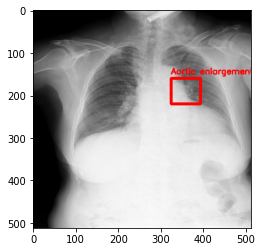

In [ ]:
fr = cv2.imread("/gdrive/MyDrive/VinBigData Chest X-ray Abnormalities Detetion/train512/051132a778e61a86eb147c7c6f564dfe.png")
frame_rgb = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
frame_rgb = cv2.rectangle(frame_rgb, (324, 160), (324 + 69, 160 + 60), (255, 0, 0), 5)
cv2.putText(frame_rgb, 'Aortic enlargement', (324, 160 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 0, 0), 2)
plt.imshow(frame_rgb)

In [26]:
train_df['x_min'] = train_df.apply(lambda row: row.x_min/512, axis =1)
train_df['y_min'] = train_df.apply(lambda row: row.y_min/512, axis =1)

train_df['x_max'] = train_df.apply(lambda row: row.x_max/512, axis =1)
train_df['y_max'] = train_df.apply(lambda row: row.y_max/512, axis =1)

train_df['x_mid'] = train_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

train_df['w'] = train_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
train_df['h'] = train_df.apply(lambda row: (row.y_max-row.y_min), axis =1)

train_df['area'] = train_df['w']*train_df['h']
train_df.head()

,image_id,x_min,y_min,x_max,y_max,class_id,x_mid,y_mid,w,h,area
0,train512/051132a778e61a86eb147c7c6f564dfe.png,0.566406,0.253906,0.701172,0.371094,Aortic enlargement,0.633789,0.312500,0.134766,0.117188,0.015793
1,train512/051132a778e61a86eb147c7c6f564dfe.png,0.412109,0.441406,0.896484,0.582031,Cardiomegaly,0.654297,0.511719,0.484375,0.140625,0.068115
2,train512/051132a778e61a86eb147c7c6f564dfe.png,0.417969,0.462891,0.884766,0.564453,Cardiomegaly,0.651367,0.513672,0.466797,0.101562,0.047409
3,train512/051132a778e61a86eb147c7c6f564dfe.png,0.691406,0.158203,0.783203,0.210938,Pleural thickening,0.737305,0.184570,0.091797,0.052734,0.004841
4,train512/051132a778e61a86eb147c7c6f564dfe.png,0.554688,0.253906,0.701172,0.371094,Aortic enlargement,0.627930,0.312500,0.146484,0.117188,0.017166


In [27]:
def convertYoloToPascal(size, coord):
    x_max = int(((2*size[0]*float(coord[0]))+(size[0]*float(coord[2])))/2)
    x_min = int(((2*size[0]*float(coord[0]))-(size[0]*float(coord[2])))/2)

    y_max = int(((2*size[1]*float(coord[1]))+(size[1]*float(coord[3])))/2)
    y_min = int(((2*size[1]*float(coord[1]))-(size[1]*float(coord[3])))/2)
    return (x_min,y_min,x_max,y_max)

convertYoloToPascal((512, 512), [0.633789, 0.312500, 0.134766, 0.117188])

(289, 129, 359, 190)

In [28]:
classes_df = pd.read_csv("/gdrive/MyDrive/VinBigData Chest X-ray Abnormalities Detetion/classes.csv", names = ["classes", "Id"])
classes_df.head()
classes_dict = dict()
for i in range(len(classes_df)):
  classes_dict[classes_df["classes"][i]]= classes_df["Id"][i]
print(classes_dict["Nodule/Mass"])

8


In [30]:
train_df['yolo_box'] = train_df[['x_min', 'y_min', 'w', 'h']].values.tolist()

print("We have {} unique images with boxes.".format(len(train_df.image_id.unique())))
unique_img_ids = train_df.image_id.unique()

%mkdir '/content/train512_vbd_label_train_data'
folder_location = "/content/train512_vbd_label_train_data"
count = 0

for img_id in unique_img_ids: # loop through all unique image ids. Remove the slice to do all images
    filt_df = train_df.query("image_id == @img_id") # filter the df to a specific id
    #all_boxes = filt_df.yolo_box.value
    #print(img_id)
    file_name = "{}/{}.txt".format(folder_location,img_id.split('.')[0]) # specify the name of the folder and get a file name
    count+=1
    print(file_name)
    with open(file_name, 'w+') as file: # append lines to file
        for i in filt_df.iterrows():
            s = f"{classes_dict[i[1].class_id]} %s %s %s %s \n" # The first number is the class name
            new_line = (s % tuple(i[1].yolo_box))
            file.write(new_line)

We have 3515 unique images with boxes.
mkdir: cannot create directory ‘/content/train512_vbd_label_train_data’: File exists
/content/train512_vbd_label_train_data/train512/051132a778e61a86eb147c7c6f564dfe.txt
/content/train512_vbd_label_train_data/train512/0c7a38f293d5f5e4846aa4ca6db4daf1.txt
/content/train512_vbd_label_train_data/train512/47ed17dcb2cbeec15182ed335a8b5a9e.txt
/content/train512_vbd_label_train_data/train512/d3637a1935a905b3c326af31389cb846.txt
/content/train512_vbd_label_train_data/train512/afb6230703512afc370f236e8fe98806.txt
/content/train512_vbd_label_train_data/train512/7c1add6833d5f0102b0d3619a1682a64.txt
/content/train512_vbd_label_train_data/train512/18a61a07e6f5f13ebfee57fa36cd8b6f.txt
/content/train512_vbd_label_train_data/train512/321c111713c3ee5385db0effb54ff568.txt
/content/train512_vbd_label_train_data/train512/80caa435b6ab5edaff4a0a758ffaec6e.txt
/content/train512_vbd_label_train_data/train512/5da264775732004f1b724b660138854a.txt
/content/train512_vbd_labe

In [31]:
val_df = pd.read_csv("/gdrive/MyDrive/VinBigData Chest X-ray Abnormalities Detetion/val.csv")
val_df.columns =['image_id','x_min', 'y_min',	'x_max', 'y_max','class_id']

val_df.head()

,image_id,x_min,y_min,x_max,y_max,class_id
0,train512/9a5094b2563a1ef3ff50dc5c7ff71345.png,441,379,462,437,Pleural effusion
1,train512/9a5094b2563a1ef3ff50dc5c7ff71345.png,441,379,462,437,Pleural thickening
2,train512/9a5094b2563a1ef3ff50dc5c7ff71345.png,171,302,408,395,Cardiomegaly
3,train512/9a5094b2563a1ef3ff50dc5c7ff71345.png,170,288,411,387,Cardiomegaly
4,train512/9a5094b2563a1ef3ff50dc5c7ff71345.png,259,157,320,212,Aortic enlargement


In [32]:
val_df['x_mid'] = val_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
val_df['y_mid'] = val_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

val_df['w'] = val_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
val_df['h'] = val_df.apply(lambda row: (row.y_max-row.y_min), axis =1)
val_df.head()

,image_id,x_min,y_min,x_max,y_max,class_id,x_mid,y_mid,w,h
0,train512/9a5094b2563a1ef3ff50dc5c7ff71345.png,441,379,462,437,Pleural effusion,451.5,408.0,21,58
1,train512/9a5094b2563a1ef3ff50dc5c7ff71345.png,441,379,462,437,Pleural thickening,451.5,408.0,21,58
2,train512/9a5094b2563a1ef3ff50dc5c7ff71345.png,171,302,408,395,Cardiomegaly,289.5,348.5,237,93
3,train512/9a5094b2563a1ef3ff50dc5c7ff71345.png,170,288,411,387,Cardiomegaly,290.5,337.5,241,99
4,train512/9a5094b2563a1ef3ff50dc5c7ff71345.png,259,157,320,212,Aortic enlargement,289.5,184.5,61,55


In [33]:
val_df['x_min'] = val_df.apply(lambda row: row.x_min/512, axis =1)
val_df['y_min'] = val_df.apply(lambda row: row.y_min/512, axis =1)

val_df['x_max'] = val_df.apply(lambda row: row.x_max/512, axis =1)
val_df['y_max'] = val_df.apply(lambda row: row.y_max/512, axis =1)

val_df['x_mid'] = val_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
val_df['y_mid'] = val_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

val_df['w'] = val_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
val_df['h'] = val_df.apply(lambda row: (row.y_max-row.y_min), axis =1)

val_df['area'] = val_df['w']*train_df['h']
val_df.head()

,image_id,x_min,y_min,x_max,y_max,class_id,x_mid,y_mid,w,h,area
0,train512/9a5094b2563a1ef3ff50dc5c7ff71345.png,0.861328,0.740234,0.902344,0.853516,Pleural effusion,0.881836,0.796875,0.041016,0.113281,0.004807
1,train512/9a5094b2563a1ef3ff50dc5c7ff71345.png,0.861328,0.740234,0.902344,0.853516,Pleural thickening,0.881836,0.796875,0.041016,0.113281,0.005768
2,train512/9a5094b2563a1ef3ff50dc5c7ff71345.png,0.333984,0.589844,0.796875,0.771484,Cardiomegaly,0.565430,0.680664,0.462891,0.181641,0.047012
3,train512/9a5094b2563a1ef3ff50dc5c7ff71345.png,0.332031,0.562500,0.802734,0.755859,Cardiomegaly,0.567383,0.659180,0.470703,0.193359,0.024822
4,train512/9a5094b2563a1ef3ff50dc5c7ff71345.png,0.505859,0.306641,0.625000,0.414062,Aortic enlargement,0.565430,0.360352,0.119141,0.107422,0.013962


In [34]:
val_df['yolo_box'] = val_df[['x_min', 'y_min', 'w', 'h']].values.tolist()

print("We have {} unique images with boxes.".format(len(val_df.image_id.unique())))
unique_img_ids = val_df.image_id.unique()

%mkdir '/content/train512_vbd_label_train_data/val512'
folder_location = "/content/train512_vbd_label_train_data/val512"
count = 0

for img_id in unique_img_ids: # loop through all unique image ids. Remove the slice to do all images
    filt_df = val_df.query("image_id == @img_id") # filter the df to a specific id
    #all_boxes = filt_df.yolo_box.value
    print(img_id)
    file_name = "{}/{}.txt".format(folder_location,img_id.split('/')[1].split('.')[0]) # specify the name of the folder and get a file name
    count+=1
    print(file_name)
    with open(file_name, 'w+') as file: # append lines to file
        for i in filt_df.iterrows():
            s = f"{classes_dict[i[1].class_id]} %s %s %s %s \n" # The first number is the class name
            new_line = (s % tuple(i[1].yolo_box))
            file.write(new_line)

We have 879 unique images with boxes.
mkdir: cannot create directory ‘/content/train512_vbd_label_train_data/val512’: File exists
train512/9a5094b2563a1ef3ff50dc5c7ff71345.png
/content/train512_vbd_label_train_data/val512/9a5094b2563a1ef3ff50dc5c7ff71345.txt
train512/1c32170b4af4ce1a3030eb8167753b06.png
/content/train512_vbd_label_train_data/val512/1c32170b4af4ce1a3030eb8167753b06.txt
train512/fb8e11c6b2886b2d41b379e0598669b9.png
/content/train512_vbd_label_train_data/val512/fb8e11c6b2886b2d41b379e0598669b9.txt
train512/0622cd29e4e0e4f198abf15614819ae8.png
/content/train512_vbd_label_train_data/val512/0622cd29e4e0e4f198abf15614819ae8.txt
train512/8e063eadea9a6aeb684c893c8598be3e.png
/content/train512_vbd_label_train_data/val512/8e063eadea9a6aeb684c893c8598be3e.txt
train512/04bb8bd7ee6f88a16623fe5c6dd4da91.png
/content/train512_vbd_label_train_data/val512/04bb8bd7ee6f88a16623fe5c6dd4da91.txt
train512/25f2c7b53a6ed09a9aaf73c30357aaf6.png
/content/train512_vbd_label_train_data/val512/25f2

In [35]:
%%capture
!zip -r "/content/yolo_labels.zip" "/content/train512_vbd_label_train_data"

In [ ]:
!ls

MyDrive
